In [30]:
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

census_by_community = gpd.read_file('Data/census_by_community1.shp')
grid_data = gpd.read_file('Data/ScooterGridId.shp')
data = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_point = data[['startx','starty']].to_numpy()

import progressbar
from shapely.geometry import shape, Polygon, Point
grid_start_coor = []
centeroid_grid = [[round(x.centroid.x,3), round(x.centroid.y,3)] for x in grid_data.geometry]
centeroid_scale_grid = [[x.centroid.x, x.centroid.y] for x in grid_data.geometry]
start_coor = [[round(x.startx,3), round(x.starty,3)] for x in data.itertuples()]
end_coor = [[round(x.endx,3), round(x.endy,3)] for x in data.itertuples()]

dataplot = pd.DataFrame(np.array(centeroid_scale_grid),columns=['x', 'y'])

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 100, max_iter=1000, init ='k-means++')

lat_long = np.array(centeroid_scale_grid)
lot_size = len(centeroid_scale_grid)
weighted_kmeans_clusters = kmeans.fit(lat_long, sample_weight = lot_size) # Compute k-means clustering.
c_group = kmeans.predict(lat_long, sample_weight = lot_size)

start_c_group = []
end_c_group = []
for i in progressbar.progressbar(range(len(start_coor))):
    for j in range(len(centeroid_grid)):
        if start_coor[i][0] == centeroid_grid[j][0] and start_coor[i][1] == centeroid_grid[j][1]:
            start_c_group.append(c_group[j])
            break;
for i in progressbar.progressbar(range(len(end_coor))):
    for j in range(len(centeroid_grid)):
        if end_coor[i][0] == centeroid_grid[j][0] and end_coor[i][1] == centeroid_grid[j][1]:
            end_c_group.append(c_group[j])
            break;

import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = c_group # Labels of each point

dataplot.plot.scatter(x = 'x', y = 'y', c=labels, s=50, cmap='viridis')
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Clustering GPS Co-ordinates to Form Regions - Weighted',fontsize=10, fontweight='bold')

100% (459478 of 459478) |################| Elapsed Time: 0:05:56 Time:  0:05:56
100% (459478 of 459478) |################| Elapsed Time: 0:06:23 Time:  0:06:23


NameError: name 'dataplot' is not defined

In [8]:
data_set = coor_data.join(date_data.join(meta_data))

Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy', 'start_date', 'class','end_cluster_group']).to_numpy()
X_data = np.concatenate((X_data,start_c_group),axis=1)
X_data = np.concatenate((X_data,end_c_group),axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [10]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

sc = MinMaxScaler(feature_range=(0,1))
X_data_n = sc.fit_transform(X_data)
Y_data_n = sc.fit_transform(Y_data)

x_train, x_test, y_train, y_test = train_test_split(X_data_n, Y_data_n, test_size=0.3, shuffle=False)

In [11]:
import numpy as np

lstm_x_train = x_train[:,0:4].reshape(len(x_train[:,0:4]),4, 1)
lstm_x_test = x_test[:,0:4].reshape(len(x_test[:,0:4]),4, 1)

In [17]:
from tensorflow.keras import layers, Model
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
inputA = layers.Input(shape=(4, 1))
inputB = layers.Input(shape=(59))

x = LSTM(units=50, batch_input_shape=(4, 1), return_sequences=True )(inputA)
x = LSTM(units=20, return_sequences=True )(x)
x = LSTM(units=10, return_sequences=False )(x)
x = Model(inputs=inputA, outputs=x)
y = Dense(50, activation="relu")(inputB)
y = Dense(30)(y)
y = Dense(10)(y)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

z = Dense(2)(combined)

model = Model(inputs=[x.input,y.input], outputs=z)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 59)]         0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 4, 50)        10400       input_11[0][0]                   
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           3000        input_12[0][0]                   
____________________________________________________________________________________________

In [35]:

from tensorflow.python.keras.callbacks import EarlyStopping

RADIUS_KM = 6378.1

def degrees_to_radians(deg):
    pi_on_180 = 0.017453292519943295
    return deg * pi_on_180

def loss_haversine(observation, prediction):    
    obv_rad = tf.map_fn(degrees_to_radians, observation)
    prev_rad = tf.map_fn(degrees_to_radians, prediction)

    dlon_dlat = obv_rad - prev_rad 
    v = dlon_dlat / 2
    v = tf.sin(v)
    v = v**2

    a = v[:,1] + tf.cos(obv_rad[:,1]) * tf.cos(prev_rad[:,1]) * v[:,0] 

    c = tf.sqrt(a)
    c = 2* tf.math.asin(c)
    c = c*RADIUS_KM
    final = tf.reduce_sum(c)

    final = final/tf.dtypes.cast(tf.shape(observation)[0], dtype= tf.float32)

    return final
    
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=[loss_haversine])

callback = EarlyStopping(monitor='loss', patience=10, mode="auto")
model.fit([lstm_x_train,x_train[:,4:]], y_train, epochs=100, validation_data=([lstm_x_test,x_test[:,4:]], y_test), callbacks=[callback])

Train on 321634 samples, validate on 137844 samples
Epoch 1/100
321634/321634 [==============================] - 168s 523us/sample - loss: 0.0155 - loss_haversine: 2.7564 - val_loss: 0.0142 - val_loss_haversine: 2.5148
Epoch 2/100
321634/321634 [==============================] - 169s 525us/sample - loss: 0.0141 - loss_haversine: 2.4927 - val_loss: 0.0127 - val_loss_haversine: 2.2486
Epoch 3/100
321634/321634 [==============================] - 193s 599us/sample - loss: 0.0135 - loss_haversine: 2.3869 - val_loss: 0.0136 - val_loss_haversine: 2.3804
Epoch 4/100
321634/321634 [==============================] - 183s 569us/sample - loss: 0.0130 - loss_haversine: 2.3072 - val_loss: 0.0120 - val_loss_haversine: 2.1202
Epoch 5/100
321634/321634 [==============================] - 190s 592us/sample - loss: 0.0127 - loss_haversine: 2.2526 - val_loss: 0.0119 - val_loss_haversine: 2.1163
Epoch 6/100
321634/321634 [==============================] - 187s 582us/sample - loss: 0.0125 - loss_haversine: 2

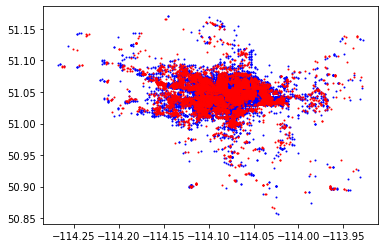

In [36]:
import matplotlib.pyplot as plt
import numpy as np
sc.fit_transform(Y_data)
result_Y = model.predict([lstm_x_test,x_test[:,4:]])


result_Y_plot = sc.inverse_transform(result_Y)
y_test_plot = sc.inverse_transform(y_test)
plt.scatter((y_test_plot[:,0]),(y_test_plot[:,1]), color='b', s= 1)
plt.scatter((result_Y_plot[:,0]), (result_Y_plot[:,1]), color='r', s= 1)



In [41]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 3)
    km = round(km, 3)
    return km

array([[0.66981375, 0.56708825],
       [0.57056653, 0.56098044],
       [0.52156276, 0.5589793 ],
       ...,
       [0.6285573 , 0.5819899 ],
       [0.67606485, 0.5670042 ],
       [0.67606485, 0.5670042 ]], dtype=float32)

100% (1563 of 1563) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1032 of 1032) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (619 of 619) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (305 of 305) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (204 of 204) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (447 of 447) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1358 of 1358) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (3467 of 3467) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5374 of 5374) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (4080 of 4080) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (4236 of 4236) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (6461 of 6461) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7760 of 7760) |###################

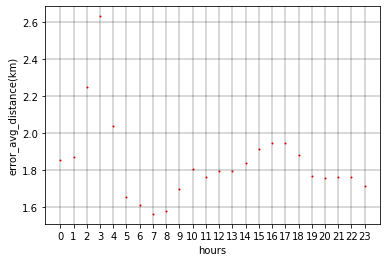

In [66]:
mae_rate_hour = []

sc.fit_transform(X_data)
for index in range(24):
    mask = np.logical_and(sc.inverse_transform(x_test)[:,3] > (index)-0.1, sc.inverse_transform(x_test)[:,3] < (index+1)-0.1)
    result_Y_hour = result_Y[mask]
    Y_test_in = y_test[mask]
    error = 0
    for i in progressbar.progressbar(range(len(Y_test_in))):
        error = error + haversine(result_Y_hour[i],Y_test_in[i])[0]
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(error_average_distance), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)


In [65]:
sc.inverse_transform(x_test)[:,2]

array([ 0., 48., 54., ..., 83.,  0.,  0.])

In [55]:
mae_rate_hour[:,0]

TypeError: list indices must be integers or slices, not tuple

100% (15875 of 15875) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (17466 of 17466) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (19102 of 19102) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (19539 of 19539) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (21257 of 21257) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (23819 of 23819) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20786 of 20786) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


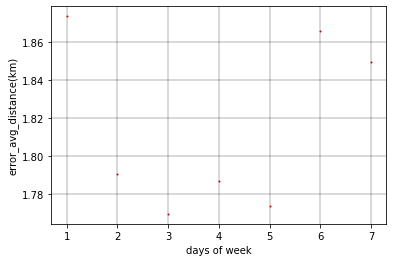

In [72]:
mae_rate_day_of_week = []

sc.fit_transform(X_data)
for index in range(7):
    mask = np.logical_and(sc.inverse_transform(x_test)[:,4] > (index)-0.1, sc.inverse_transform(x_test)[:,4] < (index+1)-0.1)
    result_Y_day_of_week = result_Y[mask]
    Y_test_in = y_test[mask]
    error = 0
    for i in progressbar.progressbar(range(len(Y_test_in))):
        error = error + haversine(result_Y_day_of_week[i],Y_test_in[i])[0]
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_day_of_week.append([float(error_average_distance), str(index+1)])

mae_rate_day_of_week = np.array(mae_rate_day_of_week, dtype=np.object)
plt.xlabel('days of week')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_day_of_week[:,1], mae_rate_day_of_week[:,0], color='r', s= 1)

array([5., 5., 5., ..., 4., 4., 4.])